In [6]:
import ctypes as ct
import numpy as np

In [7]:
dll = ct.windll.LoadLibrary("./x64/Release/rate_dll2.dll")    
y_func = dll.y
y_func.argtypes = [ct.c_double, ct.c_double, ct.c_double, ct.c_double, ct.c_double, ct.c_double, ct.c_double, ct.c_double, ct.c_double]
y_func.restype = ct.c_double

In [8]:
def y(y1, y2, tao, lambda_1, lambda_21, lambda_2, delta_0, delta_1, delta_2):
    return y_func(y1, y2, tao, lambda_1, lambda_21, lambda_2, delta_0, delta_1, delta_2)

vec_y = np.vectorize(y, otypes=[float], cache=True)

In [9]:
import pandas as pd

week_df_lst = [pd.read_csv(df_str) for df_str in ["USD1WKD156N.csv", "USD2WKD156N.csv"]]
month_df_lst = [pd.read_csv(df_str) for df_str in [f"USD{i}MTD156N.csv" for i in range(1, 10)] + [f"USD{i}MD156N.csv" for i in range(10, 13)]]

total_df_lst = week_df_lst + month_df_lst

result_df = total_df_lst[0]
for tdf in total_df_lst[1:]:
    result_df = pd.merge(result_df, tdf, on="DATE", how="outer")
    
result_df = result_df.sort_values("DATE")
result_df.index = pd.DatetimeIndex(result_df["DATE"])
del result_df["DATE"]

In [10]:
start_date = pd.datetime(2013, 4, 28)
end_date = pd.datetime(2013, 5, 3)

In [11]:
data_mat = result_df[(result_df.index >= start_date) & (result_df.index <= end_date)].values.astype(np.float64)

In [12]:
data_mat.shape

(5, 14)

In [13]:
tao_ar = np.array([1/12/4, 2/12/4, 1/12, 2/12, 3/12, 4/12, 5/12, 6/12, 7/12, 8/12, 9/12, 10/12, 11/12, 12/12])

def target(x0, tao_ar=tao_ar, target_dt=data_mat):
    return np.ravel(vec_y(x0[0], x0[1], tao_ar, x0[2], x0[3], x0[4], x0[5], x0[6], x0[7]) - target_dt)

In [14]:
from scipy.optimize import least_squares 

In [15]:
rst = least_squares(target, x0=np.random.rand(8,), method="lm")

In [16]:
rst.success

True

In [17]:
rst.x

array([ 2.73661565,  2.30751303, -0.53704662,  2.17388262, -0.5731952 ,
       -0.01001851,  0.18264239, -0.14454051])

In [188]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 20, 10

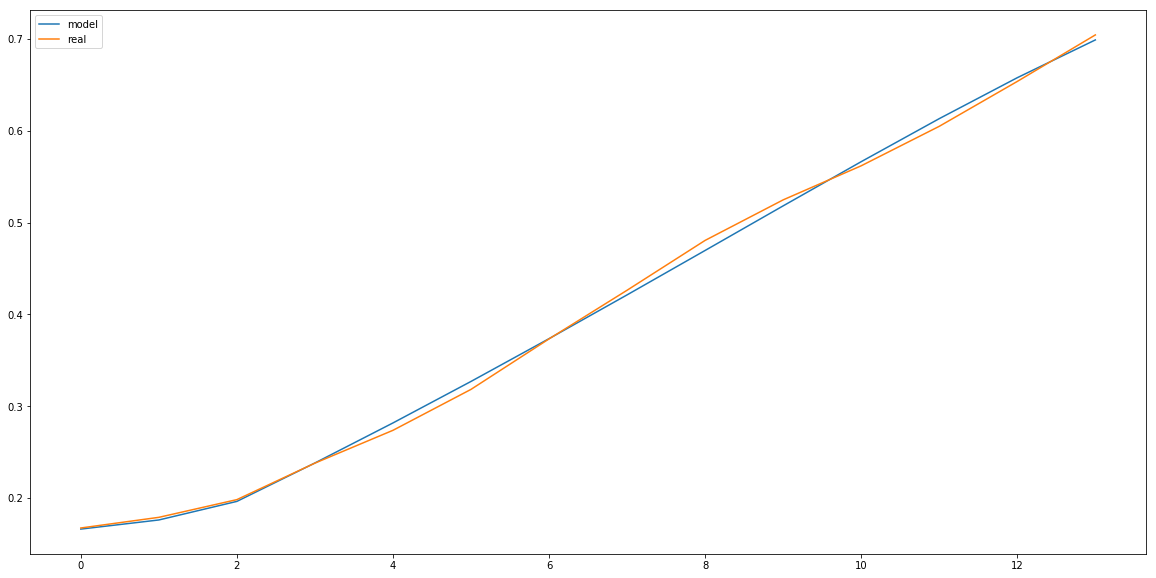

In [196]:
fig, ax = plt.subplots()
plt.plot(vec_y(rst.x[0], rst.x[1], tao_ar, rst.x[2], rst.x[3], rst.x[4], rst.x[5], rst.x[6], rst.x[7]), label="model");
plt.plot(np.mean(data_mat, axis=0), label="real")
ax.legend();